In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -qq "/content/drive/MyDrive/facemask_dataset.zip"

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPool2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing \
import RandomFlip,RandomRotation,Rescaling,RandomContrast
import matplotlib.pyplot as plt

# 기존에 만들었던 프로젝트

### 데이터셋 설정

In [6]:
#train_df 설정
train_df = image_dataset_from_directory('/content/Face Mask Dataset/Train/',
                                       labels='inferred',
                                       label_mode='binary',
                                       interpolation='nearest',
                                       image_size=[128,128],
                                       batch_size=32,
                                       shuffle=True,
                                       )

#valid_df 설정
valid_df = image_dataset_from_directory('/content/Face Mask Dataset/Validation/',
                                       labels='inferred',
                                       label_mode='binary',
                                       interpolation='nearest',
                                       image_size=[128,128],
                                       batch_size=32,
                                       shuffle=True,
                                       )

#test_df 설정
test_df = image_dataset_from_directory('/content/Face Mask Dataset/Test/',
                                       labels='inferred',
                                       label_mode='binary',
                                       interpolation='nearest',
                                       image_size=[128,128],
                                       batch_size=32,
                                       shuffle=True,
                                       )

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


마스크 착용했는 사람들 이미지와 착용하지 않은 사람들 이미지 9장을 랜덤으로 보여주기

<ipython-input-27-5b0791979edb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


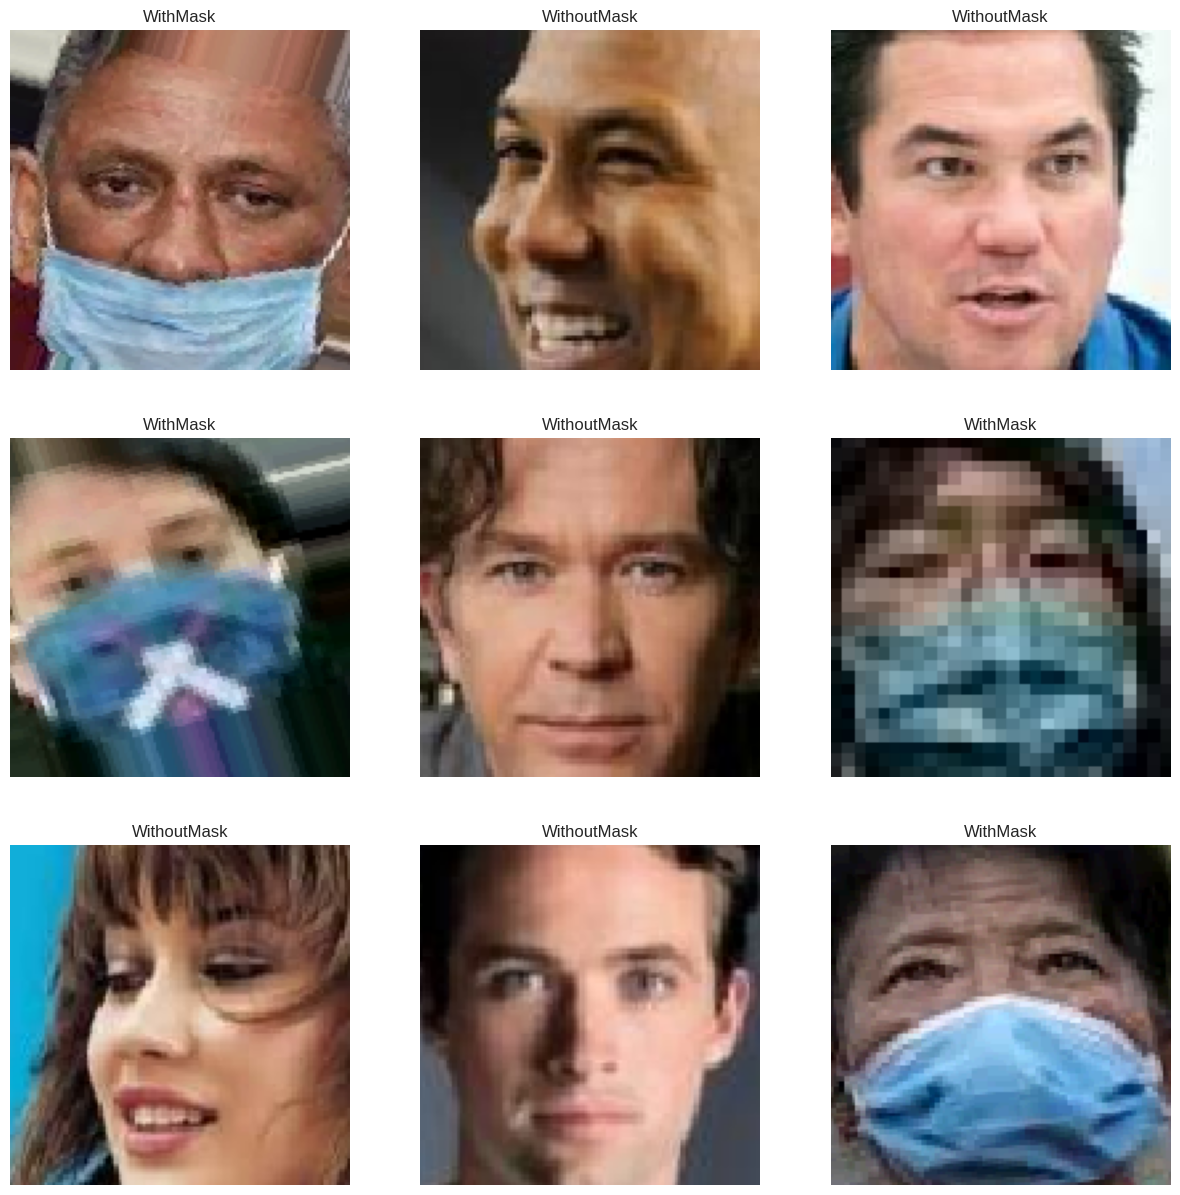

In [ ]:
class_name = train_df.class_names

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

plt.figure(figsize=(15,15))
for img, label in train_df.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_name[int(label[i])])
        plt.axis('off')

### 모델

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)
valid_df = valid_df.cache().prefetch(buffer_size=AUTOTUNE)
test_df = test_df.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
    Rescaling(1.0/255,input_shape=(128,128,3)),
    # RandomFlip(),
    # RandomRotation(0.4),
    # RandomContrast(0.3),
    
    # First Layer
    layers.Conv2D(filters=64, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Second Layer
    layers.Conv2D(filters=128, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Third Layer
    layers.Conv2D(filters=128, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Forth Layer
    layers.Conv2D(filters=128, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    # Fivth Layer
    layers.Conv2D(filters=128, kernel_size=5, activation='relu',padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6,activation='relu'),
    layers.Dense(units=1,activation='sigmoid')
    
])

모델 학습

In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(epsilon=0.02),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


history = model.fit(train_df,
                   validation_data=valid_df,
                   epochs=50, #50
                   batch_size=32, #32
                   )

print('\n*** Fit is over ***')

Epoch 1/50
313/313 [==============================] - 25s 70ms/step - loss: 0.3773 - binary_accuracy: 0.8464 - val_loss: 0.2360 - val_binary_accuracy: 0.9212
Epoch 2/50
313/313 [==============================] - 18s 57ms/step - loss: 0.1580 - binary_accuracy: 0.9421 - val_loss: 0.1266 - val_binary_accuracy: 0.9588
Epoch 3/50
313/313 [==============================] - 18s 57ms/step - loss: 0.0995 - binary_accuracy: 0.9673 - val_loss: 0.0919 - val_binary_accuracy: 0.9750
Epoch 4/50
313/313 [==============================] - 17s 55ms/step - loss: 0.0877 - binary_accuracy: 0.9707 - val_loss: 0.0613 - val_binary_accuracy: 0.9825
Epoch 5/50
313/313 [==============================] - 17s 56ms/step - loss: 0.0624 - binary_accuracy: 0.9800 - val_loss: 0.1079 - val_binary_accuracy: 0.9550
Epoch 6/50
313/313 [==============================] - 18s 57ms/step - loss: 0.0457 - binary_accuracy: 0.9845 - val_loss: 0.0547 - val_binary_accuracy: 0.9787
Epoch 7/50
313/313 [==============================] 

<Axes: >

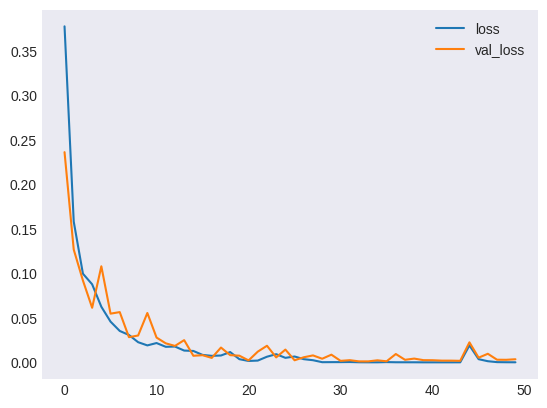

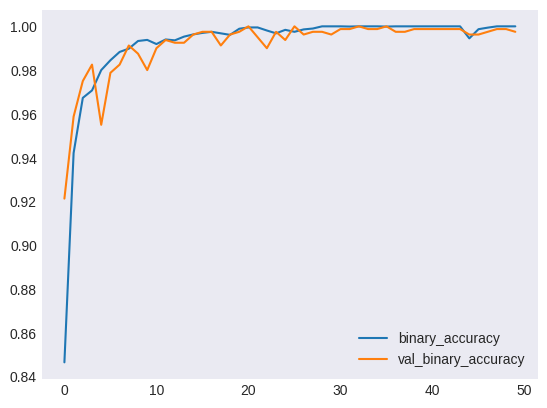

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df.loc[:,['loss','val_loss']].plot()
hist_df.loc[:,['binary_accuracy','val_binary_accuracy']].plot()
# 참고 https://dacon.io/competitions/official/235626/codeshare/1856 

In [ ]:
test_loss, test_acc = model.evaluate(valid_df, verbose=2)

25/25 - 0s - loss: 0.0035 - binary_accuracy: 0.9975 - 393ms/epoch - 16ms/step


### model evaluation
* #### epochs = 50 / batch_size = 32  
25/25 - 0s - loss: 0.0035 - binary_accuracy: 0.9975 - 393ms/epoch - 16ms/step

* #### epochs = 100 / batch_size = 64
25/25 - 0s - loss: 0.0376 - binary_accuracy: 0.9887

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      4864      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       204928    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)      

### 결과

1/1 [==============================] - 0s 18ms/step


<ipython-input-42-48a227c19b81>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (pred>0.5).astype(np.int)


1/1 [==============================] - 0s 26ms/step


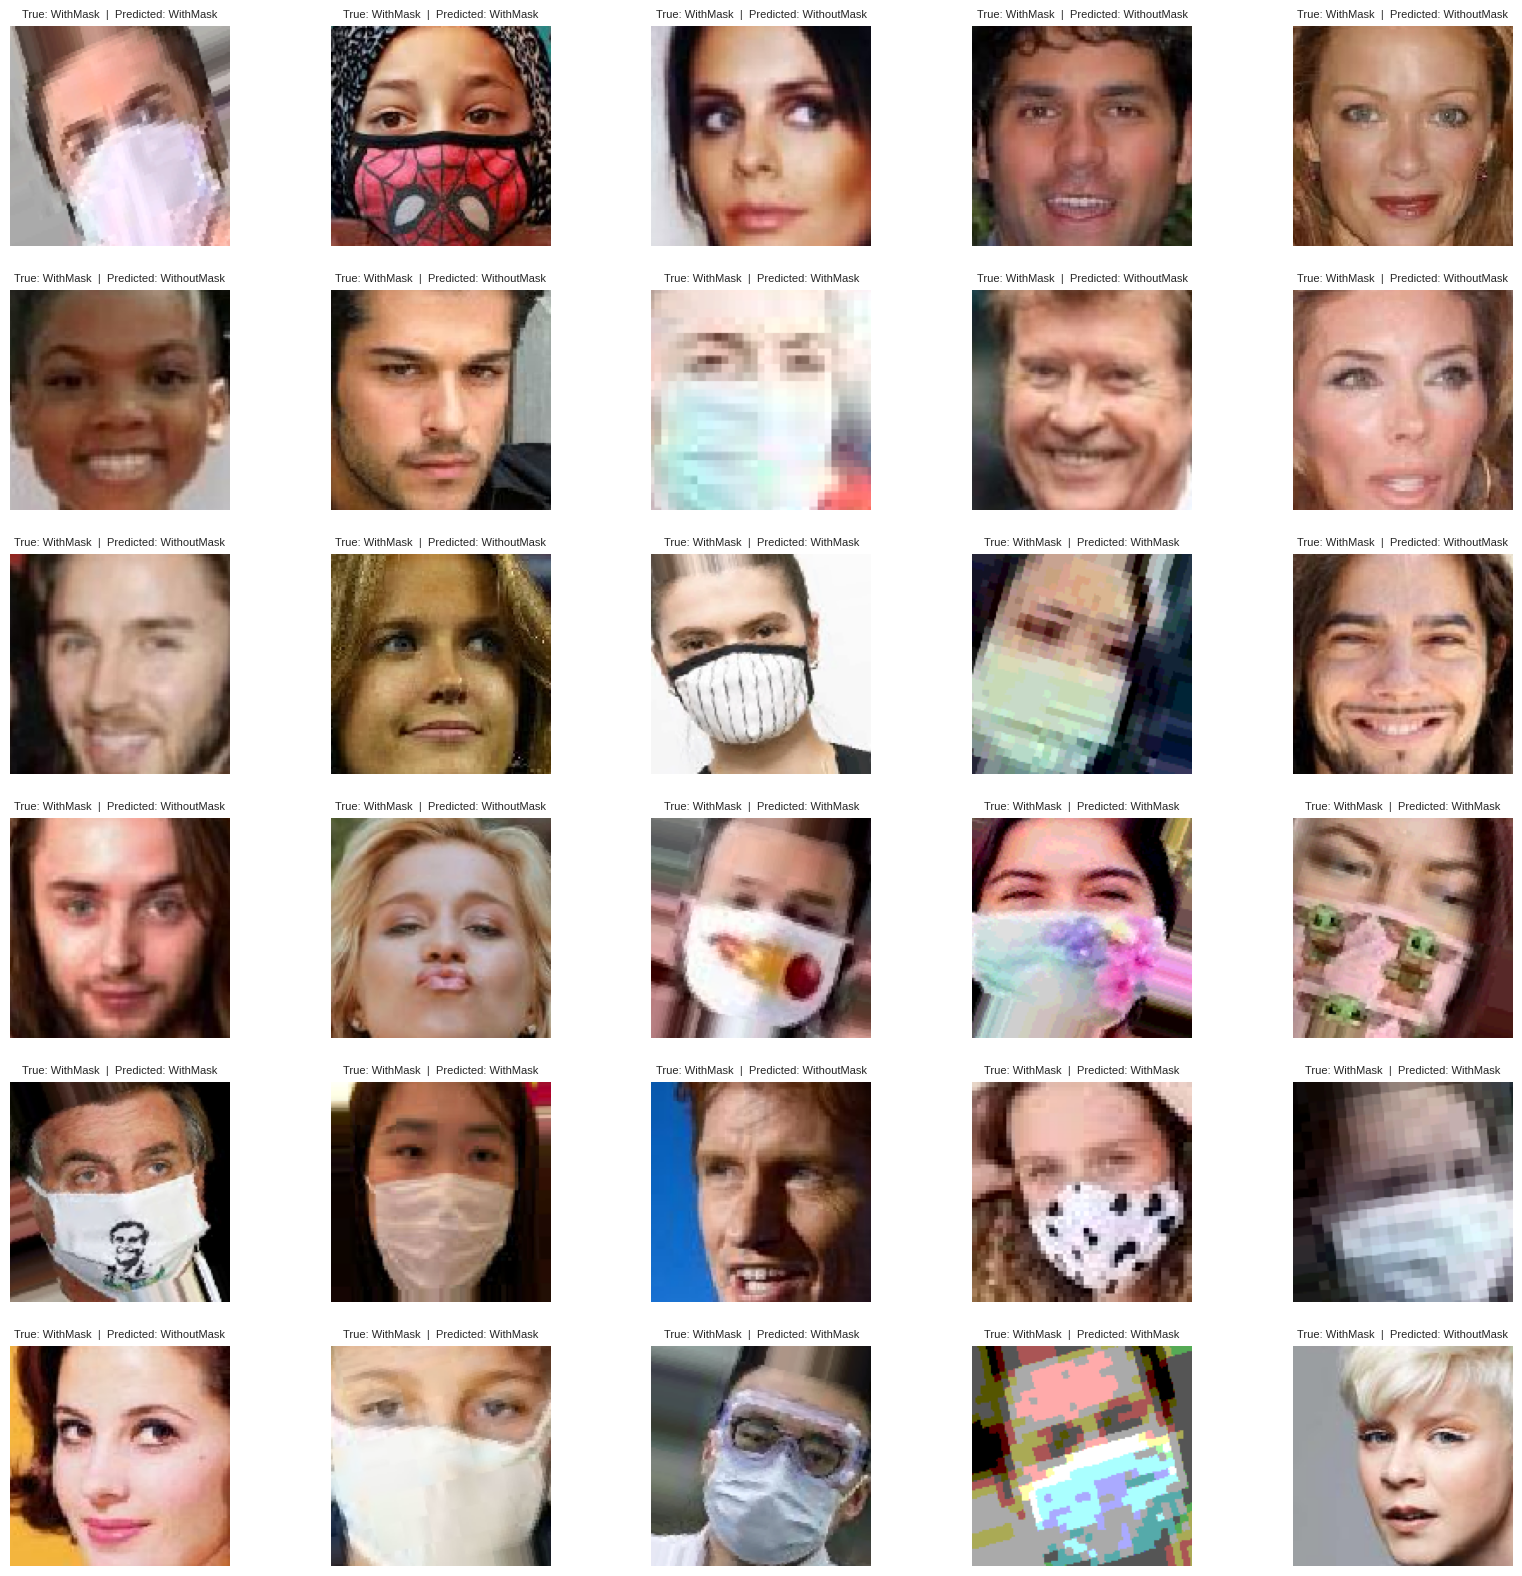

In [ ]:
def get_class(img):
    img_arr = keras.preprocessing.image.img_to_array(img)
    img_arr = tf.expand_dims(img_arr, 0)
    pred = model.predict(img_arr)
    pred = (pred>0.5).astype(np.int)
    return class_name[pred[0][0]], class_name[np.argmax(model.predict(img_arr), axis=-1)[0]]

plt.figure(figsize=(20,20))
for img , _ in test_df.take(5):
    for i in range(30):
        ax = plt.subplot(6,5,i+1)
        plt.imshow(img[i])
        predicted_class, true_class = get_class(img[i])
        plt.title(f'True: {true_class}  |  Predicted: {predicted_class}',fontsize=8)
        plt.axis('off')


# 프로젝트 수정




In [8]:
# 이미지 크기 및 배치 크기 지정
img_height = 128
img_width = 128
batch_size = 32
epochs = 30

# 데이터 경로 지정
train_dir = '/content/Face Mask Dataset/Train/'
validation_dir = '/content/Face Mask Dataset/Validation/'
test_dir = '/content/Face Mask Dataset/Test/'

#train_df 설정
train_df = image_dataset_from_directory(train_dir,
                                       interpolation='nearest', # 보간법
                                       image_size = (img_height, img_width),
                                       batch_size = batch_size,
                                       shuffle=True,
                                       )

#valid_df 설정
valid_df = image_dataset_from_directory(validation_dir,
                                       interpolation='nearest', # 보간법
                                       image_size = (img_height, img_width),
                                       batch_size = batch_size,
                                       shuffle=True,
                                       )

#test_df 설정
test_df = image_dataset_from_directory(test_dir,
                                       interpolation='nearest', # 보간법
                                       image_size = (img_height, img_width),
                                       batch_size = batch_size,
                                       shuffle=True,
                                       )

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


<ipython-input-9-b1d3dfa9073f>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


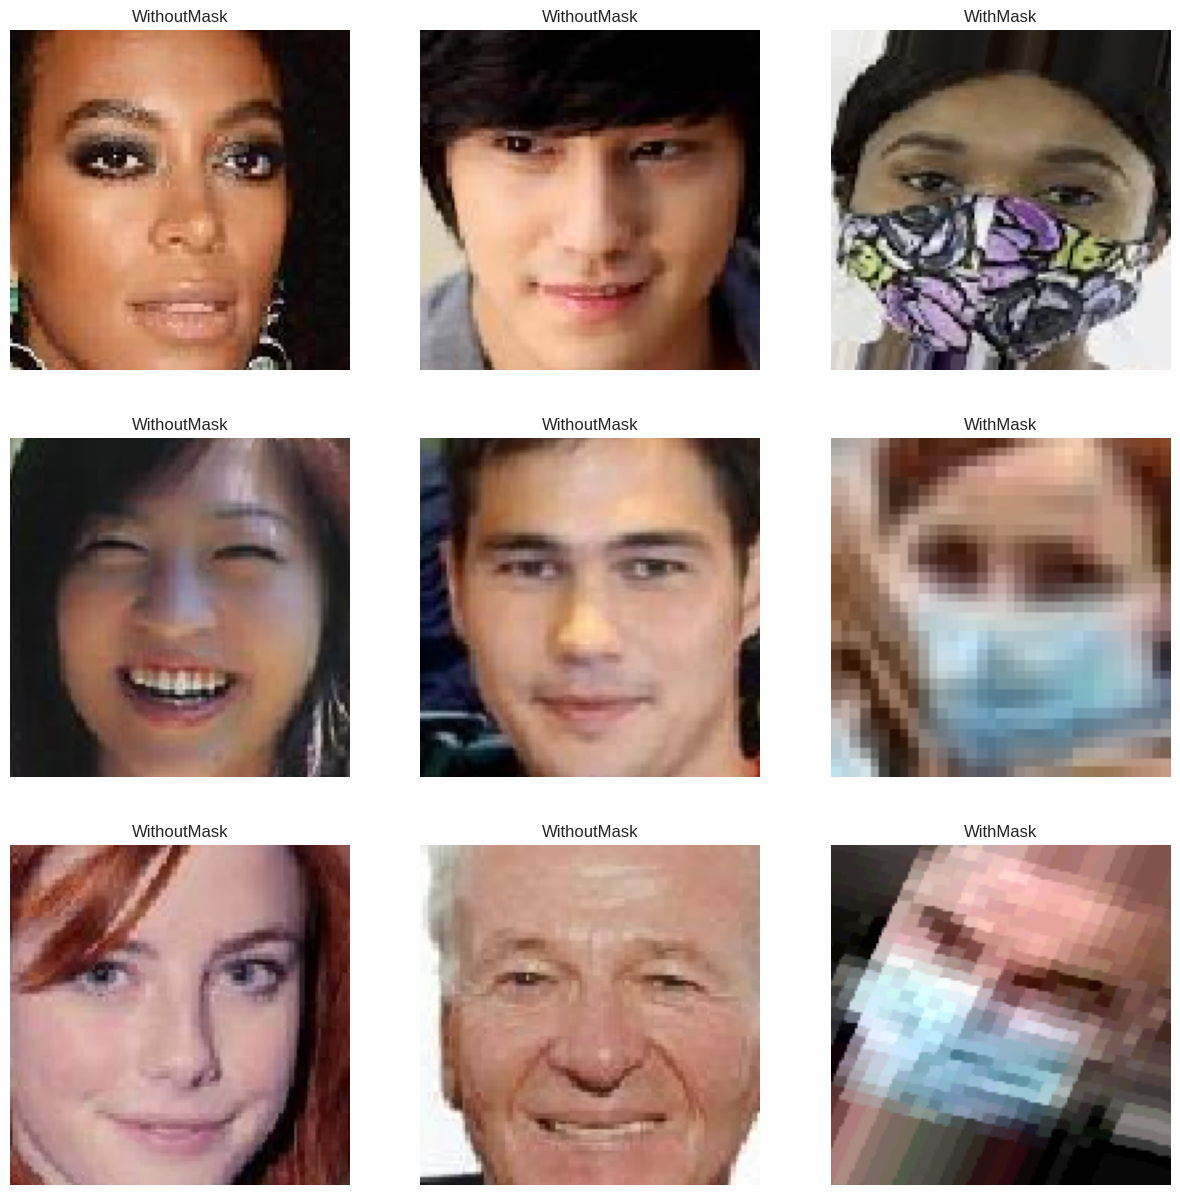

In [9]:
#마스크 착용했는 사람들 이미지와 착용하지 않은 사람들 이미지 9장을 랜덤으로 보여주기
class_name = train_df.class_names

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

plt.figure(figsize=(15,15))
for img, label in train_df.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_name[int(label[i])])
        plt.axis('off')

# 모델

In [10]:
# 데이터셋을 캐싱하고, 프리패치를 사용하여 데이터셋을 더 빠르게 처리
AUTOTUNE = tf.data.AUTOTUNE

train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)
valid_df = valid_df.cache().prefetch(buffer_size=AUTOTUNE)
test_df = test_df.cache().prefetch(buffer_size=AUTOTUNE)

# 모델 구성
num_classes = 2 # 마스크 착용한 사람, 착용하지 않은 사람의 두 개의 클래스로 구분 

model = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Layer
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    # Second Layer
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    # Third Layer
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [11]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 모델 학습
history = model.fit(
    train_df,
    validation_data=valid_df,
    epochs=epochs
)

print('\n*** Fit is over ***')

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 34s 58ms/step - loss: 0.1427 - accuracy: 0.9449 - val_loss: 0.0664 - val_accuracy: 0.9712
Epoch 2/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0408 - accuracy: 0.9851 - val_loss: 0.0216 - val_accuracy: 0.9937
Epoch 3/30
313/313 [==============================] - 5s 17ms/step - loss: 0.0315 - accuracy: 0.9886 - val_loss: 0.0277 - val_accuracy: 0.9925
Epoch 4/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0296 - accuracy: 0.9899 - val_loss: 0.0325 - val_accuracy: 0.9912
Epoch 5/30
313/313 [==============================] - 6s 18ms/step - loss: 0.0207 - accuracy: 0.9929 - val_loss: 0.0184 - val_accuracy: 0.9925
Epoch 6/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0179 - accuracy: 0.9932 - val_loss: 0.0271 - val_accuracy: 0.9875
Epoch 7/30
313/313 [==============================] - 5s 17ms/step - loss: 0.0146 - accuracy: 0.9944 - val_loss: 0.0208 - val_accuracy: 0.9937
Epoch 8/3

### 모델 평가

In [12]:
evaluate = model.evaluate(test_df)

print(f'Test set accuracy: {"{0:.2f}".format(evaluate[1]*100)}%')

31/31 [==============================] - 5s 121ms/step - loss: 0.0360 - accuracy: 0.9940
Test set accuracy: 99.40%


<Axes: >

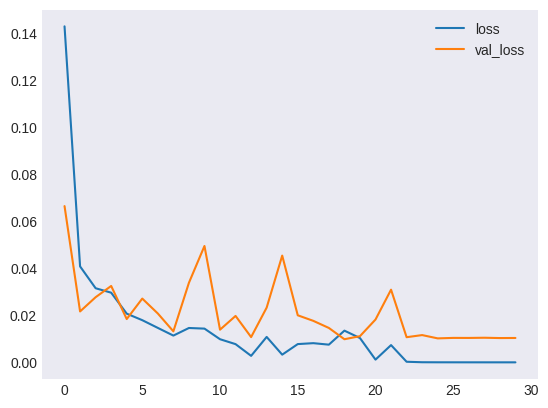

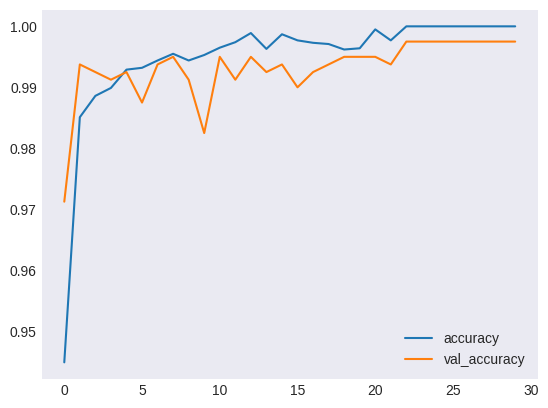

In [13]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df.loc[:,['loss','val_loss']].plot()
hist_df.loc[:,['accuracy','val_accuracy']].plot()
# 참고 https://dacon.io/competitions/official/235626/codeshare/1856 

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       7

1/1 [==============================] - 0s 19ms/step


<ipython-input-15-48a227c19b81>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (pred>0.5).astype(np.int)


1/1 [==============================] - 0s 23ms/step


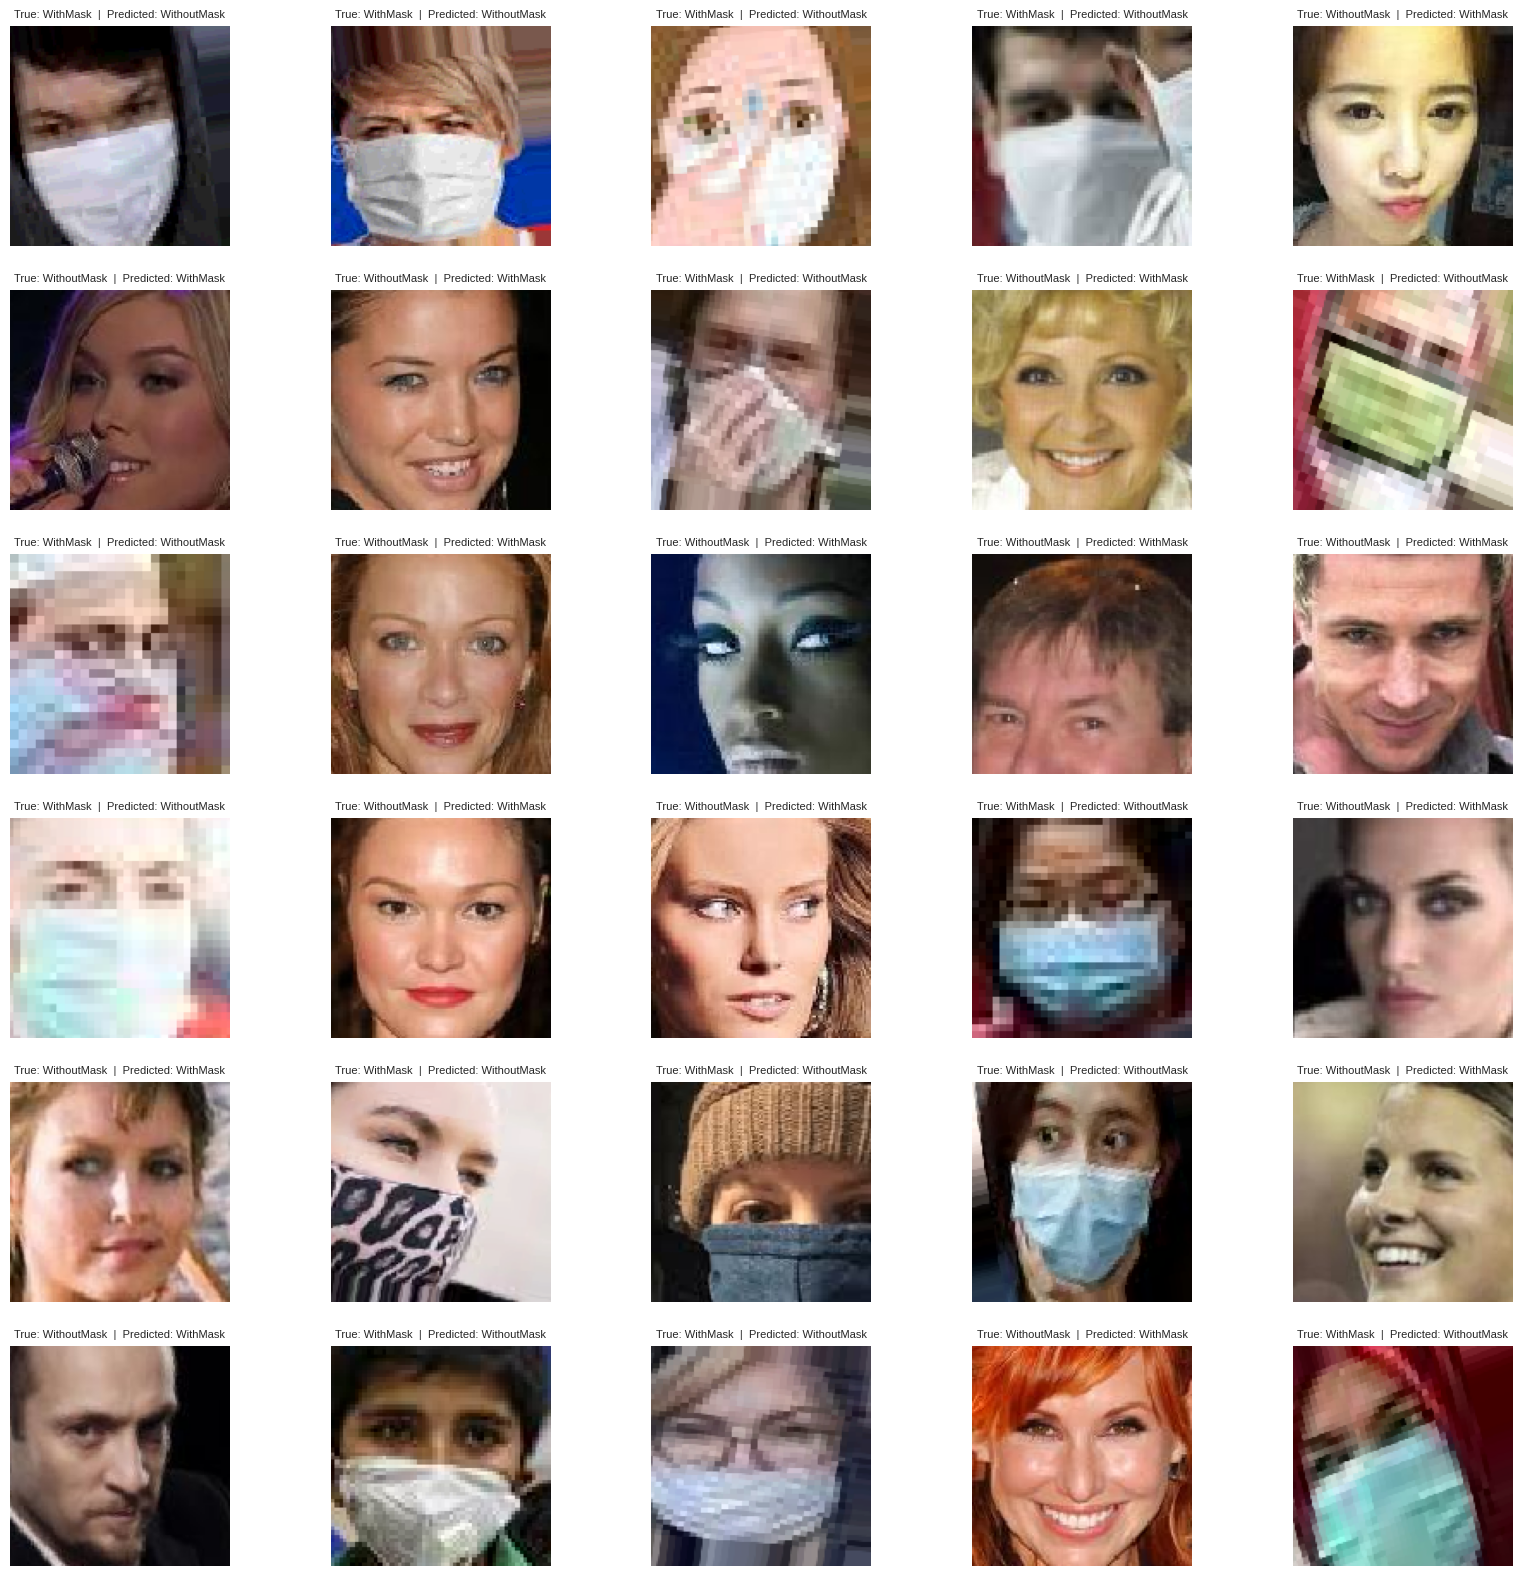

In [15]:
def get_class(img):
    img_arr = keras.preprocessing.image.img_to_array(img)
    img_arr = tf.expand_dims(img_arr, 0)
    pred = model.predict(img_arr)
    pred = (pred>0.5).astype(np.int)
    return class_name[pred[0][0]], class_name[np.argmax(model.predict(img_arr), axis=-1)[0]]

plt.figure(figsize=(20,20))
for img , _ in test_df.take(5):
    for i in range(30):
        ax = plt.subplot(6,5,i+1)
        plt.imshow(img[i])
        predicted_class, true_class = get_class(img[i])
        plt.title(f'True: {true_class}  |  Predicted: {predicted_class}',fontsize=8)
        plt.axis('off')